# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

### NOTE: need to run it in Unity environment each time

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.29 which is incompatible.
jupyter-console 6.4.3 has requirement jupyter-client>=7.0.0, but you'll have jupyter-client 5.2.4 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

## 4.1 Description of provided files
Despite having difficulties with the MADDPG running with the visual display and not a clear idea of what was "good" in terms of reward score, we've started with that set of code and files but putting the main.py 2 initial functions in the utilities.py file and taking the code of the main function out of the function and just provided inline below

### Basic structure, operations
We use a slightly modified MADDPG class that we had from the MADDPG mini-project, except now we change it to only have two interacting agents and to use separate Critic and Actor classes from the original Agent class now renamed DDPGAgent used in project 2 with some modifications. We also allow the state size and action sizes to be passed in to MADDPG along with some parameters we found useful in the past to modify during training tests. DDPGAgent in turn uses the Actor, Critic classes (along with ReplayBuffer and OUNoise helper classes) to define the details of the actor and critic local and target networks.



#### 4.1.1 First provide packages for this section for our solution

In [5]:
# KAE 4/10/2022:  this script modified from the main.py from the MADDPG mini-project
# 
# here we have only 2 agents intead of 3 and both are cooperating
#
# we also don't anticipate needing images to save gifs, etc or log directories
# we may need a keep_awake however.... since couldn't get it running locally
#
# main function that sets up environments
# perform training loop

from replaybuffer import ReplayBuffer
from maddpg import MADDPG
import torch
import numpy as np
from utilities import transpose_list, transpose_to_tensor, seeding, pre_process

# keep training awake
from workspace_utils import keep_awake

from collections import namedtuple, deque
import datetime

#### 4.1.2 Next initial various parameters for this run...

In [6]:
# amplitude of OU noise
# this slowly decreases to 0
#noise = 2
#noise_reduction = 0.9999

# initialize policy and critic
#state_size
#action_size
random_seed = 123456765
#lr_actor=1.0e-3
#lr_critic=1.0e-2
lr_actor=1.0e-4
lr_critic=1.0e-3 # typically want critic learning higher than actor
#lr_actor=1.0e-5
#lr_critic=1.0e-4 # typically want critic learning higher than actor
#lr_actor=3.0e-4
#lr_critic=3.0e-3 # typically want critic learning higher than actor
# KAE 4/13/2022: tried ranges in tau from 3e-2 to 1e-3 in 3x intervals for gamma 0.8, tau=1e-2 appeared best..
#tau=1.0e-3
tau=1.0e-2 # softmax mixing
#tau=3.0e-2
# KAE 4/13/2022: tried ranges in gamma from 0.5 to 0.99; 0.8 gamma with tau=1e-2 appeared best..
gamma=0.8 # learning combination of Q's
discount_factor=1.0 # reward discounting
maddpg = MADDPG(state_size, action_size, random_seed, \
                lr_actor=lr_actor, lr_critic=lr_critic, tau=tau, \
                gamma=gamma, discount_factor=discount_factor)

Actor BatchNorm1d on, init....
Actor BatchNorm1d on, init....
Critic BatchNorm1d on, init....
Critic BatchNorm1d on, init....
DDPG Agent.init, BUFFER_SIZE: 100000
DDPG Agent.init, BATCH_SIZE: 16
DDPG Agent.init, WEIGHT_DECAY: 0
DDPG Agent.init, UPDATE_EVERY: 5
DDPG Agent.init, TIMES_UPDATE: 1
OUNoise.reset, mu, sigma, theta, len: [ 0.  0.] 0.2 0.15 2
Actor BatchNorm1d on, init....
Actor BatchNorm1d on, init....
Critic BatchNorm1d on, init....
Critic BatchNorm1d on, init....
DDPG Agent.init, BUFFER_SIZE: 100000
DDPG Agent.init, BATCH_SIZE: 16
DDPG Agent.init, WEIGHT_DECAY: 0
DDPG Agent.init, UPDATE_EVERY: 5
DDPG Agent.init, TIMES_UPDATE: 1
OUNoise.reset, mu, sigma, theta, len: [ 0.  0.] 0.2 0.15 2


In [7]:
#maddpg.set_noise(0.1, 0.9999, True)
#maddpg.set_snoise(0.1, 0.9999, True)

In [8]:
# Initialize random number generator, now in utils, provides randome numbers 
#  seeds to numpy and torch
seeding()

# number of training episodes.
# change this to higher number to experiment. say 30000.
#number_of_episodes = 30000
# initially start with a low value for checking things out, especially since 
#  can't see anything 
number_of_episodes = 150
#number_of_episodes = 600
#number_of_episodes = 1000
#episode_length = 80
max_episode_length = 1000

# how many episodes to save policy and output
#save_interval = 1000
save_interval = 50

save_interval = np.min([number_of_episodes, save_interval])

avg_interval = np.min([number_of_episodes, save_interval])

In [9]:
#from collections import deque

print_every=10
moving_avg=100
# KAE this is useful previously to provide a 'last moving_avg' sample for the moving average
nscores_deque = deque(maxlen=moving_avg)
nbest_mean = -100
# KAE 3/19/2022: 1st time through we got learning score >36 but 
#  reloading gave us a mean of 34, so allow for 10% over
MAX_SCORE = 0.55
# KAE 3/19/2022: print the requirement score as well
REQ_SCORE = 0.5

#### 4.1.3 Finally set the actual episode loop

In [10]:
# use keep_awake to keep workspace from disconnecting
tstart = datetime.datetime.now()
## KAE 4/12/22: needed?
t = 0
max_episode_t = -1
nscores = []
nmean_scores = []
# KAE 4/12/2022: don't think we need for our application either agent0 or 1
scores =  []
#for episode in keep_awake(range(0, number_of_episodes, parallel_envs)):
for episode in keep_awake(range(0, number_of_episodes)):

    # KAE 4/11/2022: actual envrionment from above random setting to initalize the env_info
    #  The states from the env_info
    #  and the initialized scores
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    # KAE 4/11/2022: get the initial state for each agent....
    states = env_info.vector_observations                  # get the current state (for each agent)
    score = np.zeros(num_agents)                          # initialize the score (for each agent)


#    maddpg.reset() #
    
    #for calculating rewards for this particular episode - addition of all time steps
    # save info or not
    save_info = ((episode) % save_interval < 1 or episode==number_of_episodes-1)
    tmax = 0
    
    episode_t = 0
# temp values for monitoring action values....
    min_action = 1.0e38
    max_action = -1.0e38
#    for episode_t in range(episode_length):
    while True:
        t += 1
        # explore = only explore for a certain number of episodes
        # action input needs to be transposed
# KAE 4/12/22: get all actions (list) for each agent(2) in maddpg
        actions = maddpg.act(states, add_noise=False)
#        print('action, t',actions, t, episode)
        min_actionc = np.min(actions)
        max_actionc = np.max(actions)
        min_action = np.min([min_action, min_actionc])
        max_action = np.max([max_action, max_actionc])

#        noise *= noise_reduction
# KAE 4/12/22: maddpg.act is already clipped, so not needed here....
        
        # step forward one frame
# KAE 4/12/22: previous env was custom made, here we are using the unity env which has a standard output
        env_info = env.step(actions)[brain_name]
        next_states = np.array(env_info.vector_observations)
        rewards = np.array(env_info.rewards)
        dones = np.array(env_info.local_done)
        maddpg.step(states, actions, rewards, next_states, dones)
        
        score += rewards
        states = next_states
        
#        maddpg.update_noise()
        
        if np.any(dones) or  episode_t > max_episode_length:
            break 
        episode_t += 1


    max_episode_t = np.max([max_episode_t, episode_t])
    # update once after every episode_per_update
    # KAE 4/12/22: this section is, for the most part, superceeded by the agent.step
    #   function -> agent.learn for each agent
    scores.append(np.max(score))

    if episode % avg_interval == 0 or episode == number_of_episodes-1:
        avg_rewards = np.mean(scores)

    nscores_deque.append(scores)
    nscores.append(scores)
    mean_score = np.mean(nscores_deque)
    # this gives us the mean score 100 sample mean score for plotting
    nmean_scores.append(mean_score)
    # THis line remains in place, from the DDPG previous example....
#    print('\rEpisode {}\tAverage Score: {:.4f}'.format(episode, mean_score), end="")
    print('\rEpisode {} with {} iterations(emx:{}, totmx:{})\tAverage Score: {:.4f}, minact: {:.4f}, maxact: {:.4f}'.format(
        episode, t, episode_t, max_episode_t, mean_score, min_action, max_action), end="")
    # only save the current score if it is better than previous save....
    # document the ongoing process....
    if episode % print_every == 0:
        print('\nEpisode {}, Average Score: {:.4f}'.format(episode, mean_score))
    if mean_score > REQ_SCORE:
        print('\nRequirement met on Episode {}, Requirement Average Score: {:.4f}'.format(episode, mean_score))
    if mean_score > MAX_SCORE:
        print('\nFinal Episode {}, Final Average Score: {:.4f}'.format(episode, mean_score))
        break
        
    #saving model
    save_dict_list =[]
    if save_info or mean_score > nbest_mean:
#        if save_info:
#            print('\nNormal save conditions...')
        if mean_score > nbest_mean:
#        else:
            print('\nMean score: {:.4f}\t, old best: {:.4f}, max_episode: {}'.format(mean_score, nbest_mean, max_episode_t))
            nbest_mean = mean_score
        for i in range(num_agents):
            save_dict = {'actor_params' : maddpg.maddpg_agent[i].actor_local.state_dict(),
                         'actor_optim_params': maddpg.maddpg_agent[i].actor_optimizer.state_dict(),
                         'critic_params' : maddpg.maddpg_agent[i].critic_local.state_dict(),
                         'critic_optim_params' : maddpg.maddpg_agent[i].critic_optimizer.state_dict()}
            save_dict_list.append(save_dict)

#            torch.save(save_dict_list, 'checkpoint_episode-{}.pt'.format(episode))
            torch.save(save_dict_list, 'checkpoint_episode-interim.pt')
            
torch.save(save_dict_list, 'checkpoint_episode-final.pt')

# moved this up here as for some reason our solution stopped so lost the times
tend = datetime.datetime.now()


Episode 0 with 15 iterations(emx:14, totmx:14)	Average Score: 0.0000, minact: -0.0365, maxact: 0.0499
Episode 0, Average Score: 0.0000

Mean score: 0.0000	, old best: -100.0000, max_episode: 14
Episode 10 with 167 iterations(emx:13, totmx:19)	Average Score: 0.0000, minact: -0.0343, maxact: 0.0297
Episode 10, Average Score: 0.0000
Episode 20 with 339 iterations(emx:20, totmx:20)	Average Score: 0.0000, minact: -0.0222, maxact: 0.0109
Episode 20, Average Score: 0.0000
Episode 30 with 571 iterations(emx:19, totmx:37)	Average Score: 0.0000, minact: -0.1043, maxact: 0.0904
Episode 30, Average Score: 0.0000
Episode 31 with 648 iterations(emx:76, totmx:76)	Average Score: 0.0063, minact: -0.1873, maxact: 0.1811
Mean score: 0.0063	, old best: 0.0000, max_episode: 76
Episode 40 with 789 iterations(emx:14, totmx:76)	Average Score: 0.0049, minact: -0.3076, maxact: 0.3136
Episode 40, Average Score: 0.0049
Episode 41 with 808 iterations(emx:18, totmx:76)	Average Score: 0.0069, minact: -0.3787, maxact

In [11]:
dtime = tend - tstart
dt_e = float(dtime.total_seconds()) / float(number_of_episodes)
print('DDPG learning took ',dtime,'or ',dt_e,' seconds per episode')

DDPG learning took  0:00:17.945492 or  0.11963661333333335  seconds per episode


In [12]:
import matplotlib.pyplot as plt
%matplotlib inline


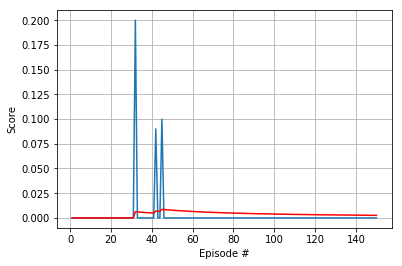

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores,label='scores')
plt.plot(np.arange(1, len(nmean_scores)+1), nmean_scores,'r-',
         label='mean scores')
plt.grid()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# NOTE: next section needs to be updated for the saved items above instead of P2 saved items....

In [14]:
## KAE 3/19/2022: here we reload the saved trained models (both actor and critic)
##   for a "replay" to demonstrate that our trained solution gives us 
##   good solutions (still)
#agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
#agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
#
## do only one "episode"
#score = np.zeros(num_agents)
#env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#states = env_info.vector_observations
#agent.reset()
## keep track of the number of turns so can get a running count
#icnt=0
#while True:
#    actions = agent.act(states, add_noise=False)
#    env_info = env.step(actions)[brain_name]           # send all actions to the environment
#    next_states = env_info.vector_observations         # get next state (for each agent)
#    rewards = env_info.rewards                         # get reward (for each agent)
#    dones = env_info.local_done                        # see if episode finished
#
#    states = next_states
#    score += rewards                                  # update the score (for each agent)
#    icnt += 1
#    print('\rTurn {}\tRunning Mean Score: {:.2f}'.format(icnt, np.mean(score)), end="")
#    if np.any(dones):
#        break 
#print('\ncurrent test scores:',score)
#print('\ncurrent mean score:',np.mean(score))

# NOTE: we don't uncomment the line below until things are working....

In [15]:
#env.close()